### 预测北京房价


免责声明：考虑到北京房价受到宏观经济、政策调整等众多因素的直接影响，预测结果仅供参考。

这个数据集的特征有：
- Area：房屋面积，平方米
- Room：房间数，间
- Living: 厅数，间
- School: 是否为学区房，0或1
- Year: 房屋建造时间，年
- Floor: 房屋所处楼层，层

目标变量：
- Value: 房屋人民币售价，万

你可以参考上面学到的内容，拿这个数据集来练习数据分割与重排、定义衡量标准、训练模型、评价模型表现、使用交叉验证对参数进行调优并选出最佳参数，比较两者的差别，最终得出最佳模型对验证集的预测分数。

###  导入数据

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import ShuffleSplit

# Pretty display for notebooks
%matplotlib inline

pk_house = pd.read_csv('bj_housing.csv')

### 快速观察数据

In [9]:
pk_house.head(3)

,Area,Value,Room,Living,School,Year,Floor
0,128,370,3,1,1,2004,21
1,68,330,1,2,1,2000,6
2,125,355,3,2,0,2003,5


### 观察总体的统计属性

In [10]:
pk_house.describe()

,Area,Value,Room,Living,School,Year,Floor
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,92.003900,342.076208,2.156216,1.277628,0.583958,1998.235524,13.326433
std,46.263242,259.406028,0.791407,0.524963,0.492925,13.126885,7.953371
min,14.000000,66.000000,1.000000,0.000000,0.000000,1014.000000,0.000000
25%,61.000000,205.000000,2.000000,1.000000,0.000000,1993.500000,6.000000
50%,83.000000,280.000000,2.000000,1.000000,1.000000,2000.000000,12.000000
75%,110.000000,395.000000,3.000000,2.000000,1.000000,2004.000000,19.000000
max,1124.000000,7450.000000,9.000000,4.000000,1.000000,2015.000000,91.000000


### 统计是否有缺失值

In [11]:
pk_house.isnull().sum()

Area      0
Value     0
Room      0
Living    0
School    0
Year      0
Floor     0
dtype: int64

无缺失值

### 根据一般性常识快速观测数据并且删选离群点

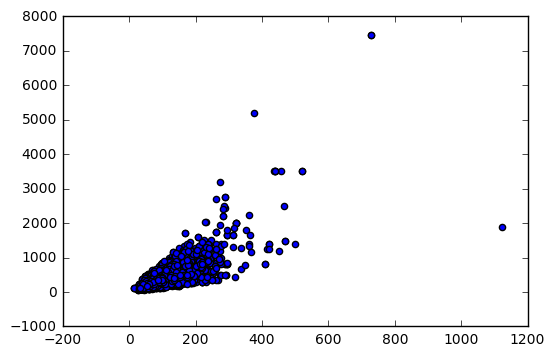

In [12]:

## 试看面积与价格是否有相关关系
plt.scatter(pk_house['Area'], pk_house['Value'])


面积和价格也有几个离群点，可以看到最上面的点代表非常大而且非常贵的一个豪宅，还有一个很大但是不是很贵（可能是郊区厂房），这些离群点非常直观，而且不会超过数据的5%， 因此都可以直接从训练集里删除。

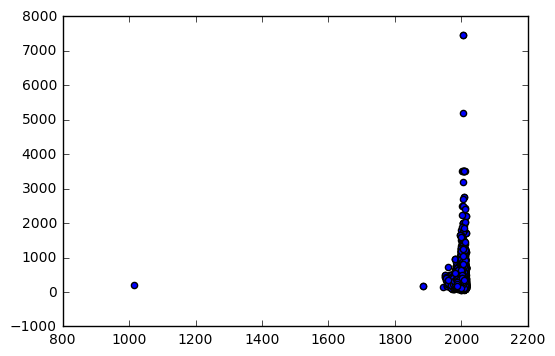

In [13]:
## 试看年份与价格是否有何关系

plt.scatter(pk_house['Year'], pk_house['Value'])

可以发现年份存在离群点，建筑年份是公元1000年，难道现在帝都现在还有北宋时期的建筑？因此这个肯定为离群点，可以直接删除。

再看一下价格分布。假设我是一个房产中介，如果我一直参考5000万以上的豪宅来学习大众房产价格的话，我的估价经验也会走向歧途。豪宅的价格带有更多的因素，很多是主管的，这对我了解大众房产市场帮助有限。因此应刨去右尾的极端情况。

In [14]:
# 大于600平米的房产
pk_house = pk_house.drop( pk_house[pk_house['Area'] > 600].index )

# 1000年前的住宅
pk_house = pk_house.drop( pk_house[pk_house['Year'] < 1200].index )

# 价格超过5000的豪宅
pk_house = pk_house.drop( pk_house[pk_house['Value'] > 5000].index )


#### 价格和面积是连续性变量，可通过对数转置可以使数据减少方差


In [15]:
# 对数转置

pk_house['Area'] = np.log(pk_house['Area'])
pk_house['Value'] = np.log(pk_house['Value'])

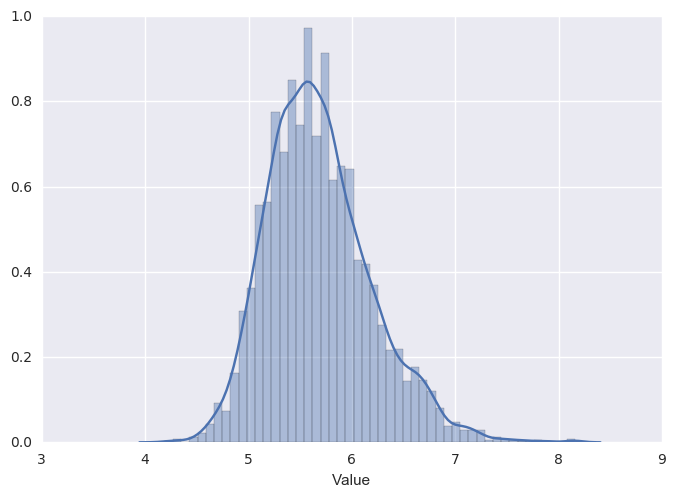

In [16]:
# 查看转置后分布

import seaborn as sns

sns.distplot(pk_house['Value'])

#### 经过转置后看起来价格更像是正态分布，可以用Jarque Bera 进行正态分布假设检验，这里就不检验了。可以看出右尾较长。

In [17]:
df = pk_house

In [18]:
df.head()

,Area,Value,Room,Living,School,Year,Floor
0,4.852030,5.913503,3,1,1,2004,21
1,4.219508,5.799093,1,2,1,2000,6
2,4.828314,5.872118,3,2,0,2003,5
3,4.859812,5.627621,2,2,0,2005,16
4,4.770685,5.828946,3,2,0,2003,6


In [19]:
x = df[['Area','Room','Living','School','Year','Floor']]
y = df['Value']

In [28]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

# 采用Lasso回归创建模型
def build_model(x,y):
    Kfold = KFold(y.shape[0], n_folds = 5)
    model = Lasso(normalize=True)
    coeffiecients = []
    
    #设定alpha取值范围
    alpha_range = np.linspace(0.0015,0.0017,30)
    grid_param = {"alpha":alpha_range}
    
    #交叉验证
    grid = GridSearchCV(estimator = model, param_grid = grid_param, cv= Kfold, scoring = 'mean_squared_error')
    grid.fit(x,y)
    display_param_results(grid.grid_scores_)
    print grid.best_params_
    return grid.best_estimator_


# 显示模型       
def view_model(model):
    print "\n Model coeffiecients"
    print "----------------------"
    
    for i, coef in enumerate(model.coef_):
        print "\tCoefficient %d %0.3f" %(i+1, coef)
    print "\n\t Intercept %0.3f" %(model.intercept_)     
    

# 显示参数结果   
def display_param_results(param_results):
    fold = 1
    for param_result in param_results:
        print "Fold %d Mean sqaured error %0.2f" %(fold, abs(param_result[1])),param_result[0]
        fold += 1

In [29]:
# 区分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 9)

# 生成多项式组合形式
poly_features = PolynomialFeatures(interaction_only =True)
poly_features.fit(x_train)

# 将原始训练集和测试集转变为带有多项式格式
x_train_poly = poly_features.transform(x_train)
x_test_poly = poly_features.transform(x_test)

choosen_model = build_model(x_train_poly, y_train)
predicted_y = choosen_model.predict(x_test_poly)


Fold 1 Mean sqaured error 0.13 {'alpha': 0.0015}
Fold 2 Mean sqaured error 0.13 {'alpha': 0.0015068965517241379}
Fold 3 Mean sqaured error 0.13 {'alpha': 0.0015137931034482758}
Fold 4 Mean sqaured error 0.13 {'alpha': 0.0015206896551724139}
Fold 5 Mean sqaured error 0.13 {'alpha': 0.0015275862068965518}
Fold 6 Mean sqaured error 0.13 {'alpha': 0.0015344827586206897}
Fold 7 Mean sqaured error 0.13 {'alpha': 0.0015413793103448276}
Fold 8 Mean sqaured error 0.14 {'alpha': 0.0015482758620689655}
Fold 9 Mean sqaured error 0.14 {'alpha': 0.0015551724137931034}
Fold 10 Mean sqaured error 0.14 {'alpha': 0.0015620689655172415}
Fold 11 Mean sqaured error 0.14 {'alpha': 0.0015689655172413794}
Fold 12 Mean sqaured error 0.14 {'alpha': 0.0015758620689655172}
Fold 13 Mean sqaured error 0.14 {'alpha': 0.0015827586206896551}
Fold 14 Mean sqaured error 0.14 {'alpha': 0.001589655172413793}
Fold 15 Mean sqaured error 0.14 {'alpha': 0.0015965517241379309}
Fold 16 Mean sqaured error 0.14 {'alpha': 0.001603

In [30]:
# metrics中的 mean_squared_error 看看误差情况

mean_squared_error(y_test, predicted_y)

0.14163457972828145

Mean squared error regression loss 为 0.14

In [31]:
# 测试一下是否 make sense

# 假设 150平米，3间卧室， 1个客厅，周围有学校， 2007年建设的10年老房，8楼。

z_test = [[np.log(150), 3, 1,1,2007,8]]

np.exp(choosen_model.predict(poly_features.transform(z_test)))

array([ 410.54843624])

#### 价格大概410万5千，像是那么回事儿。

Lasso回归模型能够用于预测北京的房价，交叉验证能够提高数据集的准确性。